# DFDC Dataset Sampling


This notebook is used to sample the full [DFDC](https://www.kaggle.com/c/deepfake-detection-challenge) dataset for deepfake detection research purposes. Sample data of 100 deepfakes and 100 real videos are extracted to be 100 frames for each video, resulting in a total of 20,000 frames of image.


In [14]:
import os
import csv
import random
import shutil
import cv2
import json
import matplotlib.pyplot as plt

In [6]:
DATASET_DIR = "/mnt/e/datasets/DFDC"
TRAIN_DATA_DIR_PREFIX = "dfdc_train"
METADATA_FILENAME = "metadata.json"

SAMPLE_DIR = "/mnt/e/samples/videos/DFDC"
SAMPLE_DEEPFAKE_DIR = os.path.join(SAMPLE_DIR, "Deepfake")
SAMPLE_ORIGINAL_VID_DIR = os.path.join(SAMPLE_DIR, "Original")

SAMPLE_FRAMES_DIR = "/mnt/e/samples/frames/DFDC"
SAMPLE_FRAMES_DEEPFAKE_DIR = os.path.join(SAMPLE_FRAMES_DIR, "Deepfake")
SAMPLE_FRAMES_ORIGINAL_VID_DIR = os.path.join(SAMPLE_FRAMES_DIR, "Original")

SAMPLE_LIST_PATH = "dfdc-list.csv"

SAMPLE_SIZE = 100
EXTRACTED_FRAME_SIZE = 100

## Video Sampling


Deepfakes are sampled by taking two random videos for each part of the dataset, of which there are 50 parts in total. The real video retrieved by taking the original video of each deepfake based on provided the metadata for each part.


In [35]:
dataset_part_dirs = [
    dir_name
    for dir_name in os.listdir(DATASET_DIR)
    if TRAIN_DATA_DIR_PREFIX in dir_name
]
part_sample_size = SAMPLE_SIZE // len(dataset_part_dirs)

In [81]:
sample_original_vid_files = []
sample_deepfake_files = []

In [71]:
def get_vid_abs_path(filenames, part_dir):
    return list(
        map(
            lambda filename: os.path.join(part_dir, filename),
            filenames,
        )
    )

In [82]:
for part_dir in dataset_part_dirs:
    part_fulldir = os.path.join(DATASET_DIR, part_dir)
    metadata_filepath = os.path.join(part_fulldir, METADATA_FILENAME)

    with open(metadata_filepath, "r") as metadata_file:
        metadata = json.load(metadata_file)
        keys = list(metadata.keys())
        original_vids = [key for key in keys if metadata[key]["label"] == "REAL"]
        sample_original_vids = random.sample(original_vids, part_sample_size)

        # Sample deepfakes based on the sampled real videos
        sample_deepfakes = []
        for original_vid in sample_original_vids:
            deepfake_filenames = [
                key
                for key in keys
                if metadata[key]["label"] == "FAKE"
                and metadata[key]["original"] == original_vid
            ]
            sample_deepfakes.append(random.choice(deepfake_filenames))

        # Get absolute path for each sample videos
        part_fulldir = os.path.join("/mnt/e/datasets/DFDC", part_dir)
        sample_original_vid_files.extend(
            get_vid_abs_path(sample_original_vids, part_fulldir)
        )
        sample_deepfake_files.extend(get_vid_abs_path(sample_deepfakes, part_fulldir))

print(f"Sampled {len(sample_original_vid_files)} original video files")
print(
    f"Sampled {len(sample_deepfake_files)} deepfake files based on the sample original videos"
)

print()

print("Sample original video:")
print(sample_original_vid_files[0])
print("\nSample deepfake:")
print(sample_deepfake_files[0])

Sampled 100 original video files
Sampled 100 deepfake files based on the sample original videos

Sample original video:
/mnt/e/datasets/DFDC/dfdc_train_part_0/doniqevxeg.mp4

Sample deepfake:
/mnt/e/datasets/DFDC/dfdc_train_part_0/nadprinqny.mp4


### Copy Sample to a Separate Directory


In [89]:
for file_path in sample_original_vid_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_ORIGINAL_VID_DIR)

In [90]:
for file_path in sample_deepfake_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_DEEPFAKE_DIR)

### Create CSV File to List Sample Video Files


In [96]:
with open(SAMPLE_LIST_PATH, "w", newline="") as sample_list_file:
    header = ["file", "label"]
    writer = csv.writer(sample_list_file)
    writer.writerow(header)

    for filename in sample_deepfake_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "deepfake"])

    for filename in sample_original_vid_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "real"])

    print(f"Sample videos filepath list generated in {SAMPLE_LIST_PATH}")

Sample videos filepath list generated in dfdc-list.csv


## Extract Sample Video Frames


### Extract Deepfakes and Real Vids Frames


In [97]:
def extract_frames(video_path, output_dir, num_frames=100):
    cap = cv2.VideoCapture(video_path)

    num_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_frames_total <= num_frames:
        frame_interval = 1
    else:
        frame_interval = int(num_frames_total / num_frames)

    frames = []
    count = 1

    video_filename = video_path.split("/")[-1]
    print(f"Extracting {video_filename}")
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if count % frame_interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            filename, _ = os.path.splitext(video_path)
            filename = filename.split("/")[-1]
            frame_count = int(count / frame_interval)
            cv2.imwrite(
                os.path.join(output_dir, f"{filename}-{frame_count}.jpg"),
                frame,
            )
            if frame_count == 100:
                break

        count += 1

    print("=> Extraction finished\n")

    cap.release()

In [100]:
for filename in os.listdir(SAMPLE_ORIGINAL_VID_DIR):
    file_path = os.path.join(SAMPLE_ORIGINAL_VID_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_ORIGINAL_VID_DIR)

Extracting aieqhlrbev.mp4
=> Extraction finished

Extracting avkeqerpsc.mp4
=> Extraction finished

Extracting bdnesbbphy.mp4
=> Extraction finished

Extracting bduhuslewa.mp4
=> Extraction finished

Extracting bhifvlgump.mp4
=> Extraction finished

Extracting biksijpktj.mp4
=> Extraction finished

Extracting bjgxevnjiu.mp4
=> Extraction finished

Extracting bkidieecdg.mp4
=> Extraction finished

Extracting cgqolgmapv.mp4
=> Extraction finished

Extracting cojtqauazp.mp4
=> Extraction finished

Extracting cozslsoswi.mp4
=> Extraction finished

Extracting cwjguxtovt.mp4
=> Extraction finished

Extracting dbvdymdpym.mp4
=> Extraction finished

Extracting deckvbmgtn.mp4
=> Extraction finished

Extracting dghebukypk.mp4
=> Extraction finished

Extracting didzujjhtg.mp4
=> Extraction finished

Extracting dsbuzyerau.mp4
=> Extraction finished

Extracting dsvrtkjwvz.mp4
=> Extraction finished

Extracting encvnokybd.mp4
=> Extraction finished

Extracting enneoqmjbk.mp4
=> Extraction finished



In [101]:
for filename in os.listdir(SAMPLE_DEEPFAKE_DIR):
    file_path = os.path.join(SAMPLE_DEEPFAKE_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_DEEPFAKE_DIR)

Extracting acrpacryoy.mp4
=> Extraction finished

Extracting bjqjyplccn.mp4
=> Extraction finished

Extracting buzlryubkx.mp4
=> Extraction finished

Extracting bwpuxeqbso.mp4
=> Extraction finished

Extracting cbnyssjaho.mp4
=> Extraction finished

Extracting cdwoinhglz.mp4
=> Extraction finished

Extracting cnvhlcuyjq.mp4
=> Extraction finished

Extracting cqdyheoqhn.mp4
=> Extraction finished

Extracting csraeqynwd.mp4
=> Extraction finished

Extracting cubernsric.mp4
=> Extraction finished

Extracting dbmamolath.mp4
=> Extraction finished

Extracting dffmijyodr.mp4
=> Extraction finished

Extracting dvdiqmebgv.mp4
=> Extraction finished

Extracting dxpqnkmhby.mp4
=> Extraction finished

Extracting efzotvfgsh.mp4
=> Extraction finished

Extracting etxenjfnaf.mp4
=> Extraction finished

Extracting euovhdcpim.mp4
=> Extraction finished

Extracting fmlrikvqcc.mp4
=> Extraction finished

Extracting fmuncwjpej.mp4
=> Extraction finished

Extracting fnazspfnbs.mp4
=> Extraction finished



### Preview Extracted Video Frames


In [102]:
NUM_PREVIEW_IMAGES = 20
NUM_ROWS = 5
NUM_COLS = NUM_PREVIEW_IMAGES // NUM_ROWS

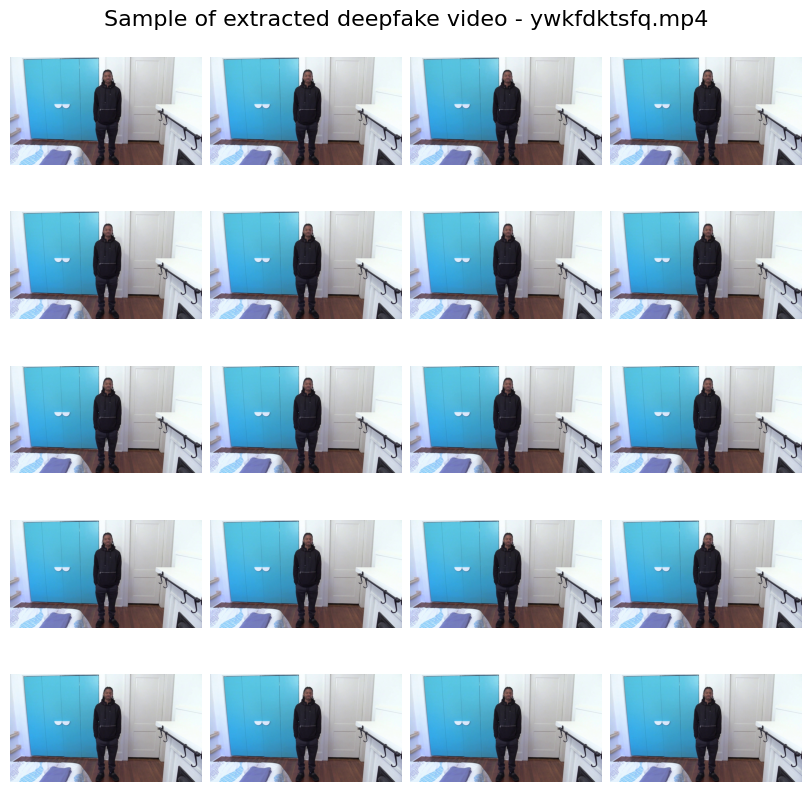

In [106]:
frame_files = [
    os.path.join(SAMPLE_FRAMES_DEEPFAKE_DIR, filename)
    for filename in os.listdir(SAMPLE_FRAMES_DEEPFAKE_DIR)[:NUM_PREVIEW_IMAGES]
]
filename = sample_deepfakes[0].split("/")[-1]

fig, axs = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(8, 8), constrained_layout=True)
fig.suptitle(f"Sample of extracted deepfake video - {filename}", fontsize=16)

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(frame_files[i])
    ax.imshow(img)
    ax.axis("off")

plt.show()